# Python Programming

# Final Project

> ## 개인 가계부 프로그램
>  1. 카테고리 설정 및 집계
>  2. 자산별 집계
>  3. 시계열 조회

분류|일자|자산|카테고리|내용|금액
--|--|--|--|--|--
지출|20160401|국민카드|기타|CJMALL|82157
지출|20160404|국민카드|의복|11번가|19860
지출|20160405|국민카드|공과금|전기요금|29430
지출|20160406|국민카드|식대|ES푸드시스템|13500
지출|20160411|국민카드|공과금|가스요금|23390
지출|20160412|국민카드|교통통신비|OLLEH모바일|45310
지출|20160413|현금|생활용품|에어컨설치|50000
지출|20160414|국민카드|건강|흥국화재해상보험|30717
지출|20160420|국민카드|건강|동부화재|47500

In [166]:
#-*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from datetime import datetime
%matplotlib inline

### 변수 초기화

In [356]:
datetime.now().date()

datetime.date(2016, 6, 25)

In [357]:
hd = ['분류','일자','자산','카테고리','내용','금액']
v = np.array(["", datetime.now().date(),"","","",0])
v

array(['', datetime.date(2016, 6, 25), '', '', '', 0], dtype=object)

### 초기데이터 입력

In [392]:
df = pd.read_excel('data.xlsx')  #, index_col = [0,1]

In [393]:
#df.index = df['Date']
df

,Date,Asset,Category,Description,Amount
0,2016-04-01,국민카드,기타,CJMALL,82157
1,2016-04-04,국민카드,의복,11번가,19860
2,2016-04-05,국민카드,공과금,전기요금,29430
3,2016-04-06,국민카드,식대,ES푸드시스템,13500
4,2016-04-11,국민카드,공과금,가스요금,23390
5,2016-04-12,국민카드,교통통신비,OLLEH모바일,45310
6,2016-04-13,현금,생활용품,에어컨 설치,50000
7,2016-04-14,국민카드,건강,흥국화재해상보험,30717
8,2016-04-20,국민카드,건강,동부화재,47500
9,2016-04-20,국민은행,공과금,관리비,10000


### 사용자 입력 받기

In [360]:
# 0. 수입/지출 구분
a = input("수입[0]/지출[1] 선택 : ) : ")
if a == 0 :
    v[0] = "In"; print("수입")
else :
    v[0] = "Ex"; print("지출")
    
# 1. 일자
a = input("일자(YYYYMMDD, 미입력시 금일) : ")
if a == "" :
    print(v[1])
else :
    v[1] = a
    print(a)

v[2] = input("자산 : ")
v[3] = input("분류 : ")
v[4] = input("내용 : ")
v[5] = input("금액 : ")

수입[0]/지출[1] 선택 : ) : 1
지출
일자(YYYYMMDD, 미입력시 금일) : 
2016-06-25
자산 : 현대카드
분류 : 교통통신비
내용 : 택시
금액 : 5000


In [387]:
v[5] = int(v[5])
v

array([datetime.date(2016, 6, 25), '현대카드', '교통통신비', '택시', 5000], dtype=object)

In [361]:
v = v[1:]

In [362]:
newidx = max(df.index)+1

In [388]:
df2 = pd.DataFrame([v], columns=['Date','Asset','Category','Description','Amount'], index=[newidx]) 
df2

,Date,Asset,Category,Description,Amount
17,2016-06-25,현대카드,교통통신비,택시,5000


In [376]:
df = df.append(df2)
df

,Date,Asset,Category,Description,Amount
0,2016-04-01 00:00:00,국민카드,기타,CJMALL,82157
1,2016-04-04 00:00:00,국민카드,의복,11번가,19860
2,2016-04-05 00:00:00,국민카드,공과금,전기요금,29430
3,2016-04-06 00:00:00,국민카드,식대,ES푸드시스템,13500
4,2016-04-11 00:00:00,국민카드,공과금,가스요금,23390
5,2016-04-12 00:00:00,국민카드,교통통신비,OLLEH모바일,45310
6,2016-04-13 00:00:00,현금,생활용품,에어컨 설치,50000
7,2016-04-14 00:00:00,국민카드,건강,흥국화재해상보험,30717
8,2016-04-20 00:00:00,국민카드,건강,동부화재,47500
9,2016-04-20 00:00:00,국민은행,공과금,관리비,10000


### 날짜타입을 문자타입으로 변경

In [389]:

#df['Date'] = 
df['Date'].dt.strftime('%Y-%m-%d')


AttributeError: Can only use .dt accessor with datetimelike values

### 인덱스 재지정

In [336]:
df.index = df['Date']

### 차트 그리기 - 일자별 구매금액

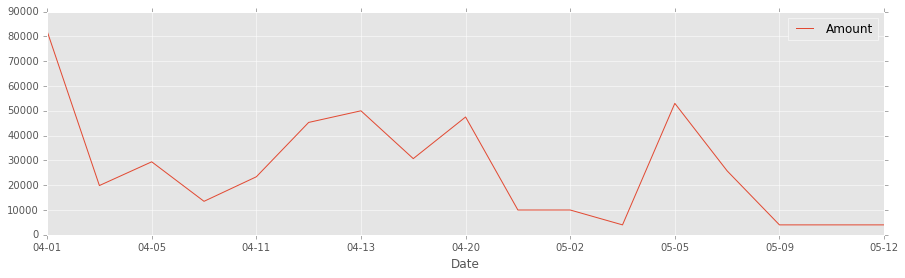

In [402]:
df.plot(kind='line', figsize=(15, 4), x=df['Date'].dt.strftime('%m-%d'))

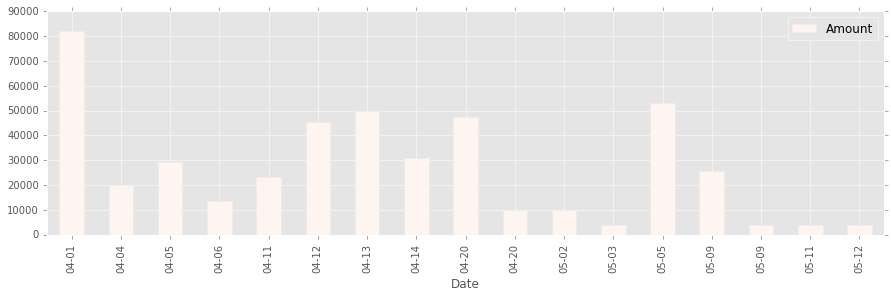

In [437]:
df.plot(kind='bar', figsize=(15, 4), x=df['Date'].dt.strftime('%m-%d'), colormap='Reds')


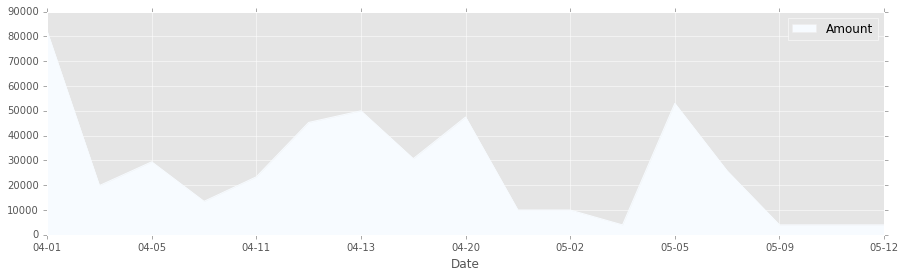

In [410]:
df.plot(kind='area', figsize=(15, 4), x=df['Date'].dt.strftime('%m-%d'), colormap='Blues')

### 자산별 지출 집계 - 금액
- 한글이 깨지나, 해결방법을 찾지 못함.

In [382]:
df.groupby("Asset")['Amount'].sum()

Asset
국민은행       10000
국민카드      396644
현금         50000
현대카드    50005000
Name: Amount, dtype: object

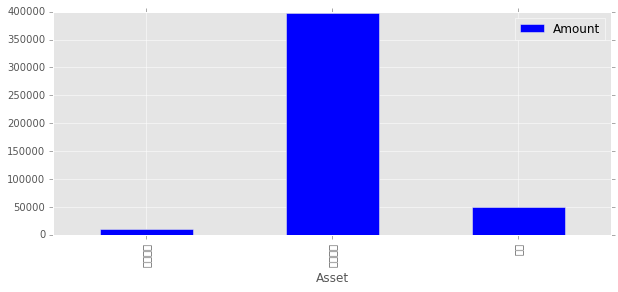

In [429]:
df.groupby("Asset").sum().plot(kind='bar', figsize=(10, 4), color='blue')

In [415]:
df.groupby("Asset")['Amount'].count()

Asset
국민은행     1
국민카드    15
현금       1
Name: Amount, dtype: int64

### 자산별 지출 집계 - 횟수
- 한글이 깨지나, 해결방법을 찾지 못함.

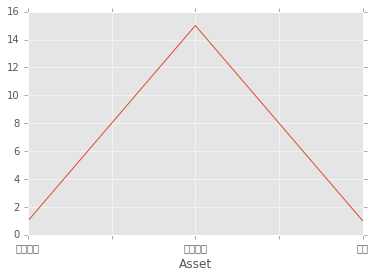

In [428]:
df.groupby("Asset")['Amount'].count().plot()

> 한 학기 동안 좋은 강의 감사합니다.
> - 빅데이터경영MBA 3기 김정미